In [1]:
#import packages
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [3]:
nc_graph = ox.load_graphml('NC_roads.graphml',folder='../Data/OSM/')

In [7]:
dcfc_df = pd.read_csv('../Data/NREL/DCFC.csv')

In [10]:
geom_point = [Point(xy) for xy in zip(dcfc_df['longitude'],dcfc_df['latitude'])]

In [13]:
dcfc_gdf = gpd.GeoDataFrame(dcfc_df,geometry=geom_point,crs=4326)

In [14]:
exits_gdf = gpd.read_file('../Data/MJBA/Exits.shp')

Link exit and dcfc features to their corresponding node in the roads network

In [28]:
def get_nodeid(thePoint):
    yx = (thePoint.y,thePoint.x)
    return ox.get_nearest_node(nc_graph,yx)

In [32]:
dcfc_gdf['node_id'] = dcfc_gdf['geometry'].apply(get_nodeid)

In [34]:
exits_gdf['node_id'] = exits_gdf['geometry'].apply(get_nodeid)

In [38]:
nodes_dcfc = dcfc_gdf['node_id'].unique()
nodes_exits = exits_gdf['node_id'].unique()

Compute distances

In [43]:
theStartNode = nodes_dcfc[0]
theStartNode

169672458

In [44]:
thePaths = nx.single_source_dijkstra_path(G = nc_graph,
                                          source = theStartNode,
                                          weight='length',
                                          cutoff = 100 * 1609.34
                                         )

In [59]:
theDistances = nx.single_source_dijkstra_path_length(G = nc_graph,
                                                     source=theStartNode,
                                                     cutoff=100 * 1609.34,
                                                     weight = 'length')

In [93]:
theDistances[169634378]

638.83

In [64]:
df = pd.DataFrame()
df['node_id'] = theDistances.keys()
df['distance'] = theDistances.values()
df['distance'] = df['distance'] / 1609.34
df.head()

,node_id,distance
0,169672458,0.000000
1,169672461,0.008455
2,5567900585,0.016066
3,5567900584,0.024915
4,5567900513,0.246039


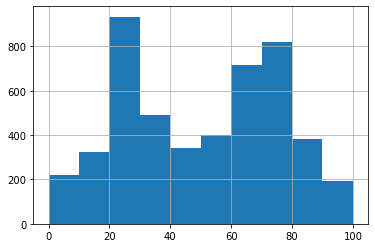

In [65]:
df['distance'].hist()

Compute all distances

In [96]:
allDistPairs = nx.all_pairs_dijkstra_path_length(nc_graph,cutoff=100* 1609.34,weight='length')

In [98]:
distance_data = {}
for distItem in allDistPairs:
    #Get the items in the tuple
    startNode_id = distItem[0]
    path_data = distItem[1]
    #Check to see if startNode is a DCFC node
    if startNode_id in nodes_dcfc: 
        #Get a list of endnodes from the path_data object
        endNodes = set(path_data.keys())
        #Get nodes that are also exits
        valid_endNodes = endNodes.intersection(set(nodes_exits))
        #iterate through valid end nodes (ie those that are exits)
        for node in valid_endNodes:
            #See if the the node already has a recorded distance
            if node in distance_data.keys():
                #Check what that distance is relative to the current DCFC-EXIT distance
                if path_data[node] < distance_data[node]:
                    distance_data[node] = path_data[node]
            else:
                distance_data[node] = path_data[node]
                

In [103]:
df_distance = pd.DataFrame()
df_distance['node_id'] = distance_data.keys()
df_distance['distance'] = distance_data.values()
df_distance['distance'] = df_distance['distance']/1609.34
df_distance.head()

,node_id,distance
0,169570817,52.466489
1,488952337,30.830719
2,173223456,46.757092
3,171985959,41.157149
4,169842216,14.200237


In [106]:
exits_gdf1 = pd.merge(left=exits_gdf,
                      right=df_distance,
                      left_on = 'node_id',
                      right_on = 'node_id',
                      how='left'
                     )

In [109]:
exits_gdf1.to_file('../Data/processed/exits_distances.shp')

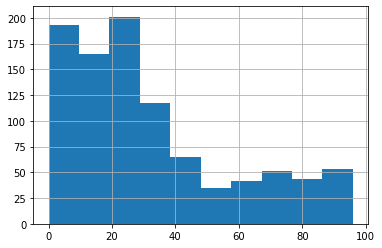

In [110]:
#Plot a histogram of distances
exits_gdf1['distance'].hist(bins=10);

In [111]:
#Create a list of exit colors, for plotting
exit_colors = []
for d in exits_gdf1['distance']:
    if d < 50: exit_colors.append('grey')  #Show exits <50 miles from DCFC as grey
    else: exit_colors.append('red')        #Show all other exits as red

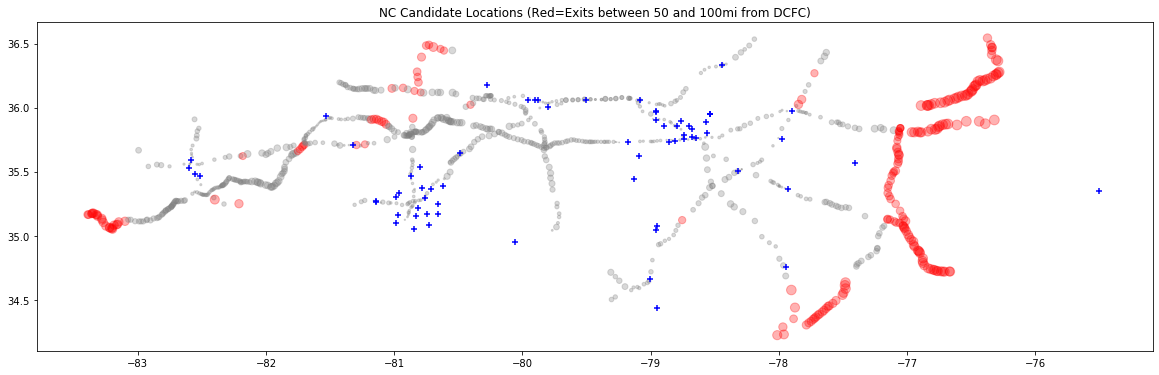

In [112]:
#Plot exits and charger locations
ax = exits_gdf1.plot(markersize='distance', #Make further exits larger
                     figsize=(20,15),       #Size of figure
                     color=exit_colors,     #Use colors set above
                     alpha=0.3)             #Set to mostly transparent
ax.set_title("NC Candidate Locations (Red=Exits between 50 and 100mi from DCFC)")

#Add the DCFC locations as small blue crosses
dcfc_gdf.plot(color='blue',marker='+',ax=ax)